In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

/Users/etriesch/dev/forest-biomass-modeling/venv/forest-biomass-modeling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
from utils import REPO_PATH, DATA_PATH, DATA_CLEAN_PATH
from utils import GEO_CRS, PROJ_AREA_CRS

from utils import set_plt_settings

set_plt_settings()

# Read in modis and forest biomass datasets

In [3]:
modis = pd.read_csv(DATA_CLEAN_PATH / 'modis_cln.csv')
modis.loc[:, 'fips'] = modis.statefp.astype(str) + modis.countyfp.astype(str).str.pad(width=3, side='left', fillchar='0')
modis.loc[:, 'fips'] = modis.fips.astype(int)
modis.tail()

,year,statefp,countyfp,name,prop_mean_mean,prop_mean_std,prop_std_mean,prop_std_std,prop_min_mean,prop_min_std,prop_max_mean,prop_max_std,mbm_sum_mean,mbm_sum_std,dbm_sum_mean,dbm_sum_std,consec_mbm_max_mean,consec_mbm_max_std,value,fips
136615,2021,56,37,Sweetwater,14623.478153,64.647533,893.483716,35.429396,13414.524338,95.786149,15843.354398,82.686401,6.031597,0.218446,1.0,0.0,3.052092,0.222308,lst,56037
136616,2021,56,39,Teton,13977.039642,104.074417,725.042605,61.096827,13021.099190,65.690499,15011.052632,146.439810,6.020243,0.431511,1.0,0.0,4.006073,0.410268,lst,56039
136617,2021,56,41,Uinta,14541.327273,137.666784,842.373837,62.005852,13405.263636,102.861851,15659.063636,215.002953,6.118182,0.442736,1.0,0.0,3.186364,0.390288,lst,56041
136618,2021,56,43,Washakie,14676.461390,212.763141,902.644565,53.118498,13378.034749,127.706524,15916.362934,243.948732,5.818533,0.605117,1.0,0.0,3.262548,0.440871,lst,56043
136619,2021,56,45,Weston,14660.644231,111.142083,857.347346,47.260968,13425.915385,110.596176,15818.973077,189.323861,5.346154,0.476660,1.0,0.0,3.011538,0.107002,lst,56045


In [4]:
fis = pd.read_csv(DATA_CLEAN_PATH / 'biomass_cln.csv')
fis = fis.rename(columns={'ord':'fips', 'c1':'county'}).drop(columns=('report'))
fis.loc[:,'state'] = fis.state.str.title()
fis.loc[:,'year_start'] = fis.year_start.astype(float)
fis.loc[:, 'statefp'] = fis.fips.astype(str).str[::-1].str[3:].str[::-1].str.replace(r'^\s*$','-1', regex=True).astype(int)
fis = fis.loc[fis.statefp > 0]
fis.head()

,county,fips,total,variance,sampling_error,sampling_error_percent,total_plots,domain_plots,non_zero_plots,r0,c0,state,year_start,year_end,statefp
0,Weston,56045,2.301287e+09,2.314102e+17,4.810511e+08,20.903570,224044.0,20.0,20.0,561801,NaN,Wyoming,2011.0,2020.0,56
1,Washakie,56043,3.086214e+09,1.490820e+18,1.220991e+09,39.562765,224044.0,15.0,15.0,561801,NaN,Wyoming,2011.0,2020.0,56
2,Uinta,56041,2.126152e+09,5.685005e+17,7.539897e+08,35.462635,224044.0,16.0,16.0,561801,NaN,Wyoming,2011.0,2020.0,56
3,Teton,56039,8.004816e+10,1.651294e+19,4.063612e+09,5.076459,224044.0,263.0,262.0,561801,NaN,Wyoming,2011.0,2020.0,56
4,Sweetwater,56037,1.935946e+09,3.164663e+17,5.625533e+08,29.058317,224044.0,25.0,25.0,561801,NaN,Wyoming,2011.0,2020.0,56


In [5]:
c_filepath = str(DATA_PATH / 'county_shapefiles/cb_2018_us_county_5m.shp')
counties = gpd.read_file(c_filepath).to_crs(GEO_CRS)
counties.columns = counties.columns.str.lower()

m2_to_km2 = 1 / 1000
km2_to_ac = 247.105
counties.loc[:, 'area_km'] = counties.to_crs(PROJ_AREA_CRS).area * m2_to_km2
counties.loc[:, 'fips'] = (counties.statefp + counties.countyfp).astype(int)
county_ac = counties.loc[:, ('fips', 'area_km')]
county_ac.head()

,fips,area_km
0,39071,1.446081e+06
1,6003,1.924795e+06
2,12033,1.940773e+06
3,17101,9.679515e+05
4,28153,2.108070e+06


## Collapse each state in modis to report ranges

In [6]:
statefps = fis.statefp.sort_values().unique()

# for state
modis_r = pd.DataFrame()
for statefp in statefps[0:]:
    # get state data and report ranges for state
    m = modis.loc[modis.statefp == statefp]
    report_ranges = fis.loc[fis.statefp == statefp, ('year_start', 'year_end')].drop_duplicates().to_numpy()

    # label report ranges
    for i,r in enumerate(report_ranges):
        m.loc[(m.year >= r[0]) & (m.year <= r[1]), ['report','year_start', 'year_end']] = (str(i), r[0], r[1])

    # collapse state to ranges
    groupcols = ['name', 'statefp', 'countyfp', 'fips', 'value', 'report', 'year_start', 'year_end']
    m = m.groupby(groupcols).mean().reset_index()
    modis_r = pd.concat([m, modis_r])


## merge datasets, make final shape, and save

In [7]:
# merge
df = pd.merge(left=fis, right=modis_r, how='left', on=('fips', 'statefp', 'year_start', 'year_end'))
df = pd.merge(left=df, right=county_ac, how='left', on='fips')
df = df.drop(columns=['year', 'r0', 'c0'])

In [8]:
# pivot long to wide
idx = ('name', 'state', 'county', 'statefp', 'countyfp', 'fips', 'report', 'year_start', 'year_end')
y = ('total', 'variance', 'sampling_error','sampling_error_percent', 'total_plots', 'domain_plots', 'non_zero_plots', 'area_km')
df_w = df.pivot_table(index=idx+y, columns='value')

df_w.columns = ['_'.join(col[::-1]).strip() for col in df_w.columns.values]
df_w = df_w.reset_index()
df_w.head()

,name,state,county,statefp,countyfp,fips,report,year_start,year_end,total,...,lst_prop_mean_std,ndvi_prop_mean_std,lst_prop_min_mean,ndvi_prop_min_mean,lst_prop_min_std,ndvi_prop_min_std,lst_prop_std_mean,ndvi_prop_std_mean,lst_prop_std_std,ndvi_prop_std_std
0,Abbeville,South Carolina,Abbeville,45,1.0,45001,0,2014.0,2020.0,1.462339e+10,...,31.769758,270.418898,14101.947802,5374.719780,23.351315,376.054385,374.215985,1049.343217,11.366537,93.242069
1,Abbeville,South Carolina,Abbeville,45,1.0,45001,1,2007.0,2013.0,1.324775e+10,...,36.237017,301.344224,14094.362637,5165.046703,25.344120,368.341678,392.860385,1037.640725,12.766874,97.682606
2,Abbeville,South Carolina,Abbeville,45,1.0,45001,2,2002.0,2006.0,1.304123e+10,...,36.104135,306.340601,14137.515385,5109.053846,27.457214,387.002949,371.273056,1154.091201,13.211450,113.778299
3,Acadia,Louisiana,Acadia,22,1.0,22001,0,2009.0,2018.0,8.708445e+09,...,33.503258,568.573268,14294.108333,4069.173333,43.634007,577.341224,341.395852,1012.359570,13.366662,162.681980
4,Acadia,Louisiana,Acadia,22,1.0,22001,1,2001.0,2008.0,4.518391e+09,...,31.866626,498.942895,14309.327083,4116.904167,36.281991,508.279131,339.240161,1010.999294,14.308331,156.714047


In [9]:
# make flag for latest report per county
# df_w.loc[:, 'last_report'] = df_w.groupby('fips')['report'].transform('min') == df_w.report
df_w.loc[:, 'last_report'] = df_w.report == '0'

In [10]:
# write final dataset
filename = 'analysis_df.csv'
filepath = DATA_CLEAN_PATH / filename
filepath.parent.mkdir(parents=True, exist_ok=True)
df_w.to_csv(filepath, index=False)

# Plot maps for report

In [11]:
# merge on FS data
county_fs = counties.drop(columns='area_km').merge(right=df_w, how='right', on='fips')
county_fs.loc[:, 'total_pkm'] = county_fs.total / county_fs.area_km

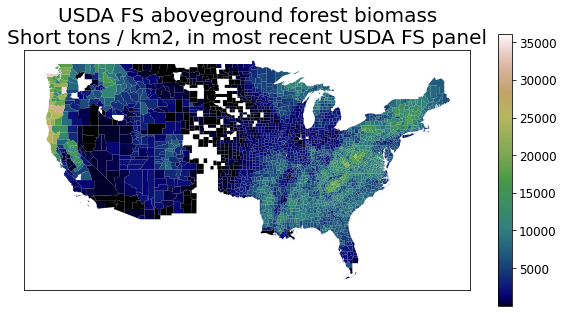

In [16]:
title = 'USDA FS aboveground forest biomass\nShort tons / km2, in most recent USDA FS panel'
gdf = county_fs.loc[county_fs.last_report]
value_col = 'total_pkm'

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column=value_col, legend=True, legend_kwds={'shrink': 0.5}, cmap='gist_earth') # https://matplotlib.org/2.0.2/users/colormaps.html
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(REPO_PATH / 'results/fig_biomass.png', bbox_inches='tight')

plt.title(title)
plt.show()

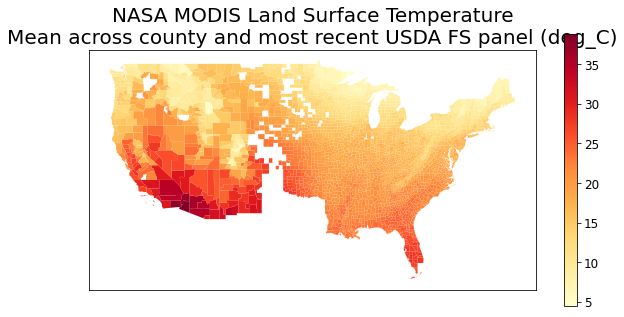

In [17]:
title = 'NASA MODIS Land Surface Temperature\nMean across county and most recent USDA FS panel (deg_C)'
gdf = county_fs.loc[county_fs.last_report]
value_col = 'lst_prop_mean_mean'
gdf.loc[:, value_col] = gdf.loc[:, value_col] * 0.02 - 273.15 # https://lpdaac.usgs.gov/products/mod11c3v006/

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column=value_col, legend=True, legend_kwds={'shrink': 0.5}, cmap='YlOrRd') # https://matplotlib.org/2.0.2/users/colormaps.html
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(REPO_PATH / 'results/fig_lst.png', bbox_inches='tight')
plt.title(title)
plt.show()

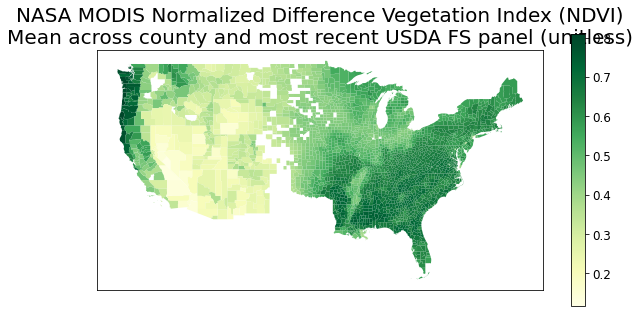

In [18]:
title = 'NASA MODIS Normalized Difference Vegetation Index (NDVI)\nMean across county and most recent USDA FS panel (unitless)'
gdf = county_fs.loc[county_fs.last_report]
value_col = 'ndvi_prop_mean_mean'
gdf.loc[:, value_col] = gdf.loc[:, value_col] * 0.0001 # https://lpdaac.usgs.gov/products/mod13c2v006/

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column=value_col, legend=True, legend_kwds={'shrink': 0.5}, cmap='YlGn') # https://matplotlib.org/2.0.2/users/colormaps.html
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(REPO_PATH / 'results/fig_ndvi.png', bbox_inches='tight')
plt.title(title)
plt.show()

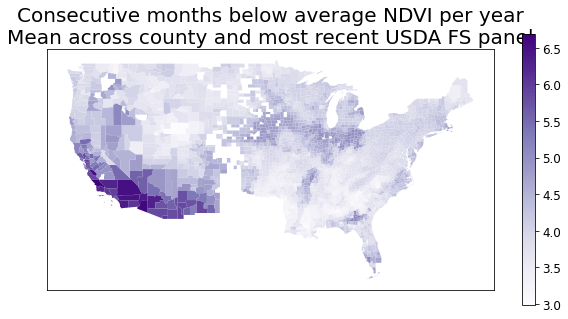

In [19]:
title = 'Consecutive months below average NDVI per year\nMean across county and most recent USDA FS panel'
gdf = county_fs.loc[county_fs.last_report]
value_col = 'ndvi_consec_mbm_max_mean'

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column=value_col, legend=True, legend_kwds={'shrink': 0.5}, cmap='Purples') # https://matplotlib.org/2.0.2/users/colormaps.html
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(REPO_PATH / 'results/fig_cmbm.png', bbox_inches='tight')
plt.title(title)
plt.show()

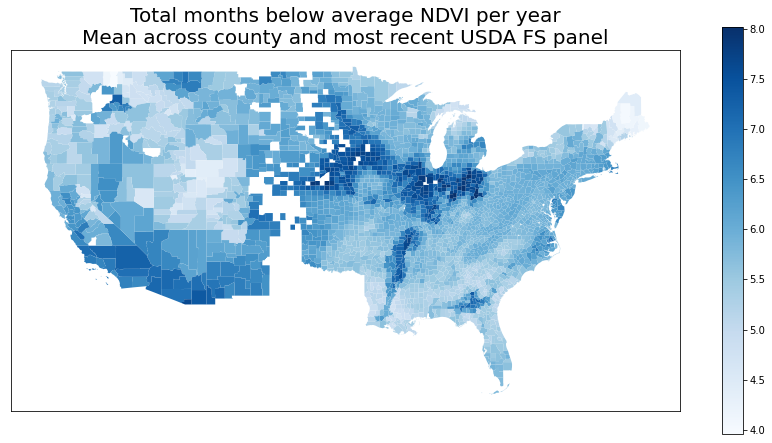

In [97]:
title = 'Total months below average NDVI per year\nMean across county and most recent USDA FS panel'
gdf = county_fs.loc[county_fs.last_report]
value_col = 'ndvi_mbm_sum_mean'

fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(ax=ax, column=value_col, legend=True, legend_kwds={'shrink': 0.5}, cmap='Blues') # https://matplotlib.org/2.0.2/users/colormaps.html
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.title(title)
plt.show()